### 1. Installs and Imports


In [1]:
# Install einops for tensor rearrangement
!pip install einops

# Import required libraries
import torch
import torch.nn as nn
from einops import rearrange
import math
import torch.nn.functional as F
from itertools import product

### 2. Hashing and Bucketing Functions


In [2]:
def hash(x, n_hashes=8, hash_size=64):
    """
     Args:
        x: Tensor of shape (batch, seq_len, dim) - token embeddings
        n_hashes: Number of hash rounds
        hash_size: Number of buckets per hash

    Returns:
        buckets: Tensor of shape (batch, seq_len, n_hashes) with bucket indices

    """
    batch, seq_len, dim = x.shape
    device = x.device


    torch.manual_seed(0)
    R = torch.randn(dim, n_hashes * hash_size, device=device)
    projected = torch.matmul(x, R)

    projected = projected.view(batch, seq_len, n_hashes, hash_size)

    buckets = projected.argmax(dim=-1)

    return buckets
def hash_vectors(x, num_buckets, n_hashes):
    B, L, D = x.shape
    device = x.device
    projections = torch.randn(n_hashes, D, num_buckets // 2, device=device)
    dots = torch.einsum('bld,hrd->blhr', x, projections)
    hashes = torch.argmax(torch.cat([dots, -dots], dim=-1), dim=-1)
    return hashes


def group_tokens_by_hash(x, hashes):
    B, L, D = x.shape
    n_hashes = hashes.shape[-1]
    groups = []
    for h in range(n_hashes):
        sorted_hashes, sort_indices = torch.sort(hashes[:, :, h], dim=-1)
        sorted_x = torch.gather(x, 1, sort_indices.unsqueeze(-1).expand(-1, -1, D))
        groups.append((sorted_x, sort_indices))
    return groups

def local_attention_in_buckets(sorted_x, bucket_size):

    B, L, D = sorted_x.shape
    num_buckets = L // bucket_size


    x_buckets = sorted_x.view(B, num_buckets, bucket_size, D)


    q = x_buckets
    k = x_buckets
    v = x_buckets


    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(D)


    attn = torch.softmax(scores, dim=-1)


    out_buckets = torch.matmul(attn, v)


    out = out_buckets.view(B, L, D)

    return out
def unsort_tokens(sorted_x, undo_sort):
    """
    Args:
        sorted_x: Tensor (batch, seq_len, dim) sorted by bucket
        undo_sort: Tensor (batch, seq_len) indices to invert sorting
    Returns:
        Tensor (batch, seq_len, dim): tokens in original order
    """
    B, L, D = sorted_x.shape
    unsorted_x = torch.zeros_like(sorted_x)

    for b in range(B):
        unsorted_x[b] = sorted_x[b][undo_sort[b]]
    return unsorted_x

### 3. Chunked Feed-Forward and Reversible Block


In [3]:
class ChunkedFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, chunk_size):
        super().__init__()
        self.chunk_size = chunk_size
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        """
        Args:
            x: Tensor (batch, seq_len, d_model)
        Returns:
            Tensor (batch, seq_len, d_model)
        """
        B, L, D = x.shape
        outputs = []

        # Process in chunks
        for i in range(0, L, self.chunk_size):
            chunk = x[:, i:i+self.chunk_size, :]
            chunk = F.relu(self.linear1(chunk))
            chunk = self.dropout(chunk)
            chunk = self.linear2(chunk)
            outputs.append(chunk)

        return torch.cat(outputs, dim=1)

class ReversibleBlock(nn.Module):
    def __init__(self, f_module, g_module):
        super().__init__()
        self.f = f_module
        self.g = g_module

    def forward(self, x1, x2):
        y1 = x1 + self.f(x2)
        y2 = x2 + self.g(y1)
        return y1, y2

    def backward_pass(self, y1, y2, grad_y1, grad_y2):
        with torch.no_grad():
            x2 = y2 - self.g(y1)
            x1 = y1 - self.f(x2)
        return x1, x2

### 4. LSH Self-Attention


In [4]:
class LSHSelfAttention(nn.Module):
    def __init__(self, dim, n_heads, bucket_size, dropout=0.0, mode='train'):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.bucket_size = bucket_size
        self.dropout = nn.Dropout(dropout)
        self.to_qk = nn.Linear(dim, dim * 2, bias=False)
        self.to_v = nn.Linear(dim, dim, bias=False)
        self.to_out = nn.Linear(dim, dim)
        self.last_attn_weights = None  # Store for visualization


    def forward(self, x):
        b, n, d = x.shape
        qk = self.to_qk(x)
        q, k = qk.chunk(2, dim=-1)
        v = self.to_v(x)

        q = q.view(b, n, self.n_heads, -1).transpose(1, 2)
        k = k.view(b, n, self.n_heads, -1).transpose(1, 2)
        v = v.view(b, n, self.n_heads, -1).transpose(1, 2)

        q = F.normalize(q, dim=-1)
        k = F.normalize(k, dim=-1)

        dots = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size(-1))

        mask = torch.eye(n, device=x.device).bool()
        dots.masked_fill_(mask[None, None, :, :], float('-inf'))

        attn = F.softmax(dots, dim=-1)
        attn = self.dropout(attn)
        self.last_attn_weights = attn.detach().cpu()  # Save attention weights
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(b, n, self.dim)

        return self.to_out(out)

### 5. Reformer Block


In [5]:
class ReformerBlock(nn.Module):
    def __init__(self, dim, n_heads, bucket_size, ffn_chunks):
        super().__init__()
        self.attn = LSHSelfAttention(dim // 2, n_heads, bucket_size)
        self.ff = ChunkedFeedForward(dim // 2, dim * 2, ffn_chunks)

    def forward(self, x):
        x1, x2 = x.chunk(2, dim=-1)

        y1 = x1 + self.attn(x2)
        y2 = x2 + self.ff(y1)

        return torch.cat([y1, y2], dim=-1)

### 6. Reformer Model


In [6]:
class ReformerModel(nn.Module):
    def __init__(self, vocab_size, dim, n_layers, n_heads, bucket_size, ffn_chunks, max_seq_len):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, dim)
        self.pos_emb = nn.Parameter(torch.randn(1, max_seq_len, dim))
        self.layers = nn.ModuleList([
            ReformerBlock(dim, n_heads, bucket_size, ffn_chunks)
            for _ in range(n_layers)
        ])
        self.to_logits = nn.Linear(dim, vocab_size)

    def forward(self, x):
        b, t = x.shape
        x = self.token_emb(x) + self.pos_emb[:, :t]

        # Reversible residual requires even dim
        if x.shape[-1] % 2 != 0:
            raise ValueError("Embedding dim must be even for reversible residuals.")

        for layer in self.layers:
            x = layer(x)

        return self.to_logits(x)

### 7. Generation and Checkpointing Functions


In [7]:
def generate_sequence(model, start_seq, max_len, device):
    model.eval()
    generated = start_seq.to(device)

    with torch.no_grad():
        for _ in range(max_len - start_seq.size(1)):
            logits = model(generated)
            next_token_logits = logits[:, -1, :]
            probs = torch.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            generated = torch.cat([generated, next_token], dim=1)

    return generated

# Save model checkpoint
def save_checkpoint(model, optimizer, epoch, filepath):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at {filepath}")

# Load model checkpoint
def load_checkpoint(model, optimizer, filepath, device):
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded from {filepath}, resuming from epoch {epoch}")
    return epoch

### 8. Evaluation Function


In [8]:
def evaluate_reformer(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            total_loss += loss.item() * x.size(0)
            total_tokens += x.size(0) * x.size(1)

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    print(f"Validation Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}")
    return avg_loss, perplexity

### 9. Hyperparameter Tuning


In [9]:
# Define hyperparameter grid
param_grid = {
    'dim': [64, 128],
    'n_layers': [2, 4],
    'bucket_size': [16, 32],
    'learning_rate': [1e-3, 5e-4],
}

# Simple function to train & evaluate one config
def train_and_evaluate(config):
    print(f"Training with config: {config}")

    model = ReformerModel(
        vocab_size=vocab_size,
        dim=config['dim'],
        n_layers=config['n_layers'],
        n_heads=4,              # fixed for simplicity
        bucket_size=config['bucket_size'],
        ffn_chunks=16,
        max_seq_len=seq_len
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.CrossEntropyLoss()

    # Dataset and loaders
    train_dataset = CopyDataset(seq_len, vocab_size, size=500)
    val_dataset = CopyDataset(seq_len, vocab_size, size=100)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

    # Training loop (short, e.g. 3 epochs for demo)
    loss_history = []
    for epoch in range(3):
        epoch_loss_history = train_reformer(model, train_loader, optimizer, criterion, device, epochs=1)
        loss_history.extend(epoch_loss_history)

    # Validation
    val_loss, val_ppl = evaluate_reformer(model, val_loader, criterion, device)

    return model, val_loss, val_ppl, loss_history

# Define missing variables
vocab_size = 100
seq_len = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CopyDataset(torch.utils.data.Dataset):
    def __init__(self, seq_len, vocab_size, size=1000):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        x = torch.randint(1, self.vocab_size, (self.seq_len,))
        y = x.clone()
        return x, y

def train_reformer(model, dataloader, optimizer, criterion, device, epochs):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
    return loss_history


# Run sweep
results = []
all_loss_histories = {}
best_model = None
best_loss = float('inf')

for values in product(*param_grid.values()):
    config = dict(zip(param_grid.keys(), values))
    model, val_loss, val_ppl, loss_history = train_and_evaluate(config)
    results.append((config, val_loss, val_ppl))
    all_loss_histories[str(config)] = loss_history

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        best_config = config
        best_loss_history = loss_history


# Print summary
for config, loss, ppl in results:
    print(f"Config: {config}, Val Loss: {loss:.4f}, Perplexity: {ppl:.4f}")

print(f"\nBest performing model config: {best_config}")

Training with config: {'dim': 64, 'n_layers': 2, 'bucket_size': 16, 'learning_rate': 0.001}
Validation Loss: 0.0119, Perplexity: 1.0120
Training with config: {'dim': 64, 'n_layers': 2, 'bucket_size': 16, 'learning_rate': 0.0005}
Validation Loss: 0.0250, Perplexity: 1.0253
Training with config: {'dim': 64, 'n_layers': 2, 'bucket_size': 32, 'learning_rate': 0.001}
Validation Loss: 0.0117, Perplexity: 1.0117
Training with config: {'dim': 64, 'n_layers': 2, 'bucket_size': 32, 'learning_rate': 0.0005}
Validation Loss: 0.0246, Perplexity: 1.0249
Training with config: {'dim': 64, 'n_layers': 4, 'bucket_size': 16, 'learning_rate': 0.001}
Validation Loss: 0.0065, Perplexity: 1.0065
Training with config: {'dim': 64, 'n_layers': 4, 'bucket_size': 16, 'learning_rate': 0.0005}
Validation Loss: 0.0209, Perplexity: 1.0212
Training with config: {'dim': 64, 'n_layers': 4, 'bucket_size': 32, 'learning_rate': 0.001}
Validation Loss: 0.0074, Perplexity: 1.0074
Training with config: {'dim': 64, 'n_layers':

### 10. Training Loss Visualization

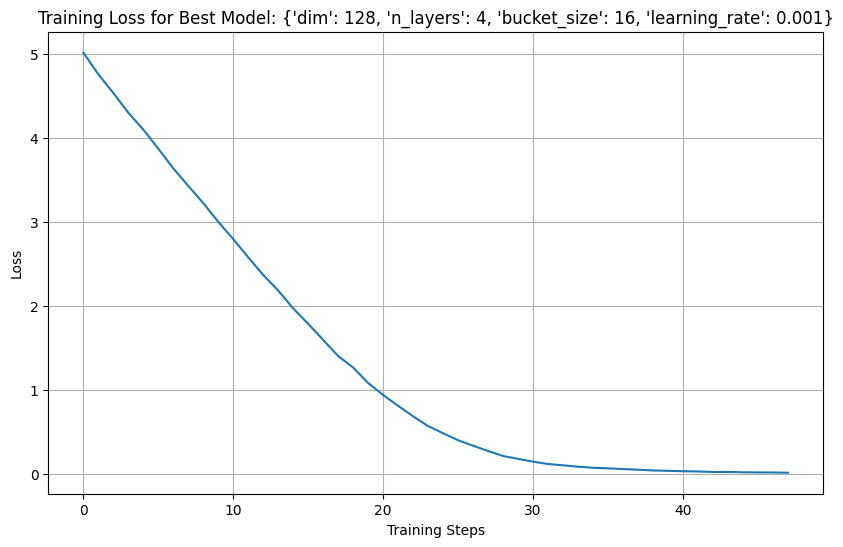

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(best_loss_history)
plt.title(f"Training Loss for Best Model: {best_config}")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

### 11. Attention Visualization

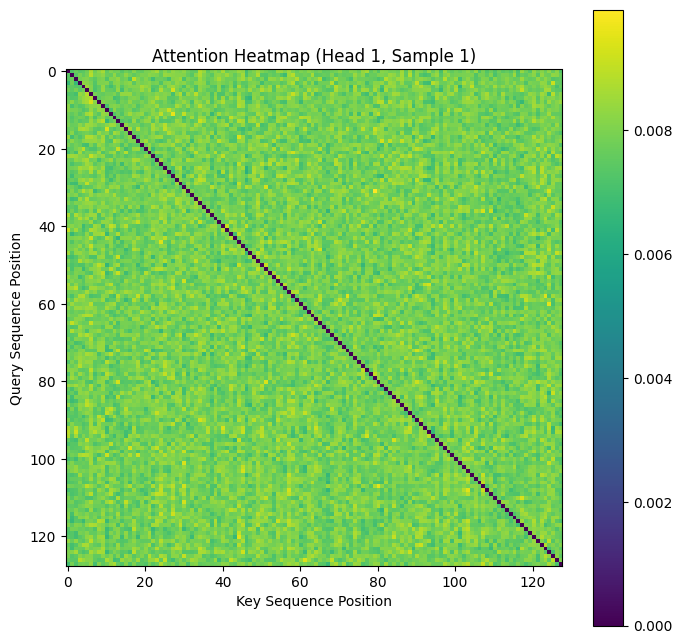

In [12]:
import matplotlib.pyplot as plt

# Instantiate the best model
best_model = ReformerModel(
    vocab_size=vocab_size,
    dim=best_config['dim'],
    n_layers=best_config['n_layers'],
    n_heads=4,
    bucket_size=best_config['bucket_size'],
    ffn_chunks=16,
    max_seq_len=seq_len
).to(device)

# Load a single batch from the validation loader
val_dataset = CopyDataset(seq_len, vocab_size, size=100)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
sample_batch, _ = next(iter(val_loader))
sample_batch = sample_batch.to(device)

# Forward pass to get attention weights
best_model(sample_batch)

# Get the attention weights from the last layer's attention module
# Note: The current implementation stores attention weights in the LSHSelfAttention module.
# We will access the last ReversibleBlock's attention module.
last_layer_attn_weights = best_model.layers[-1].attn.last_attn_weights

# Visualize the attention weights for the first head of the first item in the batch
plt.figure(figsize=(8, 8))
plt.imshow(last_layer_attn_weights[0, 0], cmap='viridis')
plt.title('Attention Heatmap (Head 1, Sample 1)')
plt.xlabel('Key Sequence Position')
plt.ylabel('Query Sequence Position')
plt.colorbar()
plt.show()

### 12. Text Generation

In [13]:
def generate_text(model, start_seq, max_len, device):
    model.eval()
    generated = start_seq.to(device)

    with torch.no_grad():
        for _ in range(max_len - start_seq.size(1)):
            logits = model(generated)
            next_token_logits = logits[:, -1, :]
            probs = torch.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            generated = torch.cat([generated, next_token], dim=1)

    return generated

# Create a sample starting sequence
start_sequence = torch.randint(1, vocab_size, (1, 10), dtype=torch.long)

# Generate text using the best model
generated_sequence = generate_text(best_model, start_sequence, 50, device)

print("Original Sequence:", start_sequence.squeeze().tolist())
print("Generated Sequence:", generated_sequence.squeeze().tolist())

Original Sequence: [91, 34, 47, 25, 99, 68, 18, 16, 2, 66]
Generated Sequence: [91, 34, 47, 25, 99, 68, 18, 16, 2, 66, 48, 60, 77, 5, 14, 47, 75, 72, 69, 15, 4, 48, 31, 15, 54, 98, 41, 1, 15, 54, 76, 18, 38, 64, 64, 88, 46, 0, 17, 2, 54, 53, 37, 52, 82, 65, 33, 31, 71, 96]
